In [5]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pre_processing import preprocess_tweet

data_dir = "./data"
vocab_size = 10000  # Only consider the top 10k words
max_input_len = 25 # max number of words in a sentece


In [6]:
# Load dataset

df = pd.read_csv(f'{data_dir}/processed_tweets.csv')
df['processed_text'] = df['processed_text'].astype(str)

df.head()

,text,processed_text,target
0,i d have responded if i were going,i d have responded if i were going,neutral
1,sooo sad,sooo sad,negative
2,bullying me,bullying me,negative
3,leave me alone,leave me alone,negative
4,sons of,sons of,negative


In [7]:
# Data Preparation

tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(df['processed_text'])

"""
This function will convert a given sentence into tokenized padded sequence to
be input in the model.
Example:
    - "I love the new design of this car!" -> [1, 2, 3, 4, 5, 6, ... n]
"""
def transform_to_model_input(text_data: list[str] | list[list[str]]) -> np.ndarray:
    sequences = tokenizer.texts_to_sequences(text_data)
    return pad_sequences(sequences, maxlen=max_input_len, padding='post', truncating='post')

input_data = transform_to_model_input(df['processed_text'])

# Labels/Target: categories to predict
label_mapping = {'neutral': 0, 'positive': 1, 'negative': 2}
labels = df['target'].map(label_mapping).values

# Convert to one-hot encoding
labels = tf.keras.utils.to_categorical(labels, num_classes=3)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(input_data, labels, test_size=0.2, random_state=42)


In [8]:
# Pre-Trained embeddings
def load_glove_embeddings(glove_file_path):
    embeddings_index = {}
    with open(glove_file_path, "r", encoding="utf-8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype="float32")
            embeddings_index[word] = coefs
    return embeddings_index


glove_file_path = f"{data_dir}/glove.twitter.27B.25d.txt"
embeddings_index = load_glove_embeddings(glove_file_path)


def create_embedding_matrix(word_index, embeddings_index, embedding_dim, vocab_size):
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    for word, i in word_index.items():
        if i < vocab_size:
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
    return embedding_matrix


# Create embedding matrix
# This matrix will be used as input weights for the embedding layer in the model
embedding_matrix = create_embedding_matrix(
    tokenizer.word_index, embeddings_index, max_input_len, vocab_size
)

In [9]:
# Create a CNN model for text classification
def create_cnn_model():
    model = models.Sequential()

    # Embedding layer
    # Make use of pre-trained embeddings as weights for the embedding layer (GloVe)
    model.add(
        layers.Embedding(
            input_dim=vocab_size,
            output_dim=max_input_len,
            weights=[embedding_matrix],
            trainable=False,
        )
    )

    # Convolutional layer: using filter sizes equivalent to detecting n-grams (e.g., n=3)
    # In this case: 625 different combinations of 2 words (2-gram)
    model.add(
        layers.Conv1D(filters=625, kernel_size=2, activation="relu")
    )  # Acts as n-gram detector
    model.add(layers.GlobalMaxPooling1D())  # Pool over the entire sequence

    # Add dropout for regularization
    model.add(layers.Dropout(0.5))

    # Fully connected (dense) layer
    model.add(layers.Dense(625, activation="relu"))

    # Add another dropout layer
    model.add(layers.Dropout(0.5))

    model.add(layers.Dense(3, activation="softmax"))

    # Compile the model with appropriate loss and optimizer
    learning_rate = 0.001  # How fast it will learn
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )

    return model

In [10]:
# Train the CNN model
cnn_model = create_cnn_model()
history = cnn_model.fit(
    X_train, y_train, epochs=10, batch_size=80, validation_data=(X_test, y_test)
)

Epoch 1/10


/Users/darlyn/.local/share/virtualenvs/cnn_sentiment_classificator-f-Jc8J_M/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


275/275 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6880 - loss: 0.7386 - val_accuracy: 0.7944 - val_loss: 0.5320
Epoch 2/10
275/275 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7803 - loss: 0.5589 - val_accuracy: 0.8130 - val_loss: 0.5039
Epoch 3/10
275/275 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7920 - loss: 0.5258 - val_accuracy: 0.8077 - val_loss: 0.4936
Epoch 4/10
275/275 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8108 - loss: 0.4904 - val_accuracy: 0.8164 - val_loss: 0.4793
Epoch 5/10
275/275 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8176 - loss: 0.4737 - val_accuracy: 0.8261 - val_loss: 0.4693
Epoch 6/10
275/275 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8238 - loss: 0.4582 - val_accuracy: 0.8295 - val_loss: 0.4611
Epoch 7/10
275/275 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8253 - loss: 0.4444 - val_accuracy: 0.8270 - val_loss: 0.4597
Epoch 8/10
275/275 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8299 - loss: 0.4362 - val_accuracy: 0.8305 - val_

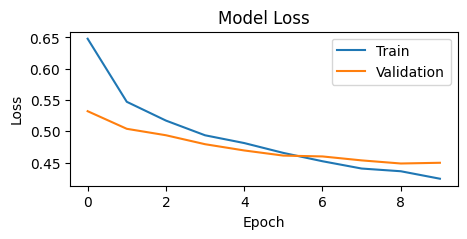

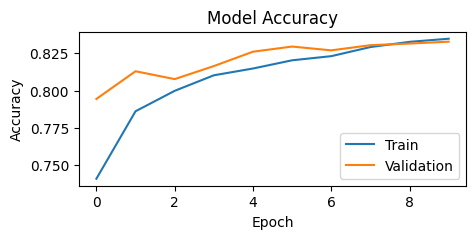

In [11]:
# Summarize history for loss
plt.figure(figsize=(5,2))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Summarize history for accuracy
plt.figure(figsize=(5,2))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

In [12]:
# Evaluate the model on the test data
test_loss, test_acc = cnn_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc}")


172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8254 - loss: 0.4492
Test Accuracy: 0.8328179121017456


In [13]:
# Manual testing

tweets = [
    "I love the new design of this car!",
    "The weather today is just okay.",
    "I'm so disappointed with the service I received.",
    "This movie was absolutely fantastic!",
    "The food was mediocre at best.",
    "I can't believe how rude the staff was.",
    "What a beautiful day!",
    "The product quality is just average.",
    "I'm really unhappy with my purchase.", 
    "This place is amazing!",
    "The event was neither good nor bad.",
    "I'm so frustrated with the delays.",
    "Had a great time with friends!",
    "The meeting was quite boring.",
    "I'm very upset with the outcome.",
    "This is the best experience I've ever had!",
    "The presentation was just fine.",
    "I'm extremely dissatisfied with the service.",
    "Feeling so happy and content!",
    "The performance was just okay."
]

predictions = []
for t in tweets:
    cleaned_text = preprocess_tweet(t)
    transformed = transform_to_model_input([cleaned_text])
    model_predictions = cnn_model.predict([transformed])

    prediction = {}
    prediction["tweet"] = t

    label_mapping = {
        "neutral": "neutral 😐",
        "positive": "positive 👍",
        "negative": "negative 👎",
    }


    for z in zip([k for k, v in label_mapping.items()], list(model_predictions[0])):
        prediction[label_mapping[z[0]]] = z[1]

    predictions.append(prediction)



predictions_df = pd.DataFrame(predictions)
predictions_df



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


,tweet,neutral 😐,positive 👍,negative 👎
0,I love the new design of this car!,0.001022,0.998971,0.000007
1,The weather today is just okay.,0.657692,0.206397,0.135910
2,I'm so disappointed with the service I received.,0.423157,0.121969,0.454874
3,This movie was absolutely fantastic!,0.000269,0.999690,0.000041
4,The food was mediocre at best.,0.261383,0.718107,0.020510
5,I can't believe how rude the staff was.,0.252046,0.030777,0.717177
6,What a beautiful day!,0.004464,0.993686,0.001850
7,The product quality is just average.,0.731175,0.090314,0.178510
8,I'm really unhappy with my purchase.,0.238583,0.115446,0.645971
9,This place is amazing!,0.000064,0.999917,0.000019
